# Project 2, Part 2 - Web Scraping and Data Analysis
Emily Feuss

Scraping a list of all Wordle words that have been played so far and running some statistics on letters used. Want to look at how each letter is used and in what positions. Also want to consider analyzing use of "double" letters - as in same letter used twice, not necessarily in succession. This all should be set up to run every day if you want to continue to run it and add in the new words

### Chapters:
- Web Scraping
- Exploratory Data Analysis
- Data Analysis: **Single Letter Counts**
- Data Analysis: **Y-Only Vowel Words**
- Data Analysis: **Letter Usage Per Location in the Word**
- Data Analysis: **Double & Triple Letter Usage**
- Data Analysis: **Letter Pairs**

---

## Web Scraping

First website didn't work, felt like I was getting blocked and then looked as TOS and it says no web scraping, so perhaps there's a block up. Even though I didn't see any limitations in robots.txt

**website with daily Wordle words:**<br>
https://screenrant.com/wordle-answers-updated-word-puzzle-guide/ (cannot use)

https://www.techradar.com/news/past-wordle-answers (ultimately used)


In [483]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import time
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
url='https://www.techradar.com/news/past-wordle-answers'
response = requests.get(url)
status = response.status_code
if status == 200:
    page = response.text
    soup = bs(page)
else:
    print(f"Oops! Received status code {status}")

In [3]:
#print(soup.prettify())
#type(soup)

In [4]:
wordles = soup.find_all(class_='table__body__row')

In [7]:
wordle_list = []

for day in wordles:
    game = day.find(class_='table_body__data')
    g = game.text
    date = game.next_sibling
    d = date.text
    word = date.next_sibling
    w = word.text
    wordle_list.append({'Game':g,'Date':d, 'Word':w})

#print(wordle_list)

### This step had me caught up for a bit, because I struggled with how to get each element out of the daily row since they all had the same class descriptor! As soon as I realized how next_sibling worked though, that helped immensely to move through the list.

In [15]:
wordle = pd.DataFrame(wordle_list)

In [16]:
wordle

,Game,Date,Word
0,1008,"Saturday, 23 March 2024",RISEN
1,1007,"Friday, 22 March 2024",DECAY
2,1006,"Thursday, 21 March 2024",SHADE
3,1005,"Wednesday, 20 March 2024",LINGO
4,1004,"Tuesday, 19 March 2024",ABIDE
...,...,...,...
1008,0,"Saturday, 19 June 2021",CIGAR
1009,325,"Tuesday, 10 May 2022",GECKO
1010,324,"Monday, 9 May 2022",SHINE
1011,284,"Wednesday, 30 March 2022",STOVE


---
## Exploratory Data Analysis

### There were a few days when Wordle transitioned from its original website to NYT that 2 different words were used. I think I will consider analyzing both words for those days, as they are all strictly speaking Wordle words.

This poses a potentially interesting question. Should I do any analyzing on the original words vs. the NYT words used? Will need to figure out the dates of transition, and then try to figure out which of the double words was played on which website. Food for thought.


In [56]:
wordle.duplicated(subset=['Date'])

0       False
1       False
2       False
3       False
4       False
        ...  
1008    False
1009     True
1010     True
1011     True
1012     True
Length: 1013, dtype: bool

In [18]:
dupes = wordle.duplicated(subset=['Date'])
dupe_count = dupes.sum()
dupe_count

4

Appears that there were only 4 days of duplicate answers. Rows 1008 - 1012 are duplicates. I'll have to search by that date to find the other word.

In [20]:
wordle.loc[1009:1012]

,Game,Date,Word
1009,325,"Tuesday, 10 May 2022",GECKO
1010,324,"Monday, 9 May 2022",SHINE
1011,284,"Wednesday, 30 March 2022",STOVE
1012,241,"Tuesday, 15 February 2022",AROMA


### OK, interesting. These dates do not line up to be just a transition period. According to the website, it was also due to the NYT changing/removing certain words and this causing misalignments.

In [40]:
dupe1 = wordle.query('Date == "Tuesday, 10 May 2022"')
dupe1

,Game,Date,Word,Dupe
683,325,"Tuesday, 10 May 2022",GECKO,False
1009,325,"Tuesday, 10 May 2022",GECKO,True


### Hmm, my scraping didn't get the second duplicate answer. Need to update the dataframe.

In [140]:
wordle_list2 =[]

for day in wordles:
    game = day.find(class_='table_body__data')
    g = game.text
    date = game.next_sibling
    d = date.text
    word = date.next_sibling
    w = word.text
    duplicate = word.next_sibling
    if duplicate == None:
         pass
    else:
        w = duplicate.text
    wordle_list2.append({'Game':g,'Date':d, 'Word':w})

In [141]:
wordle2 = pd.DataFrame(wordle_list2)
wordle2

,Game,Date,Word
0,1008,"Saturday, 23 March 2024",RISEN
1,1007,"Friday, 22 March 2024",DECAY
2,1006,"Thursday, 21 March 2024",SHADE
3,1005,"Wednesday, 20 March 2024",LINGO
4,1004,"Tuesday, 19 March 2024",ABIDE
...,...,...,...
1008,0,"Saturday, 19 June 2021",CIGAR
1009,325,"Tuesday, 10 May 2022",BUTCH
1010,324,"Monday, 9 May 2022",FETUS
1011,284,"Wednesday, 30 March 2022",HARRY


In [142]:
dupe2 = wordle2.query('Date == "Tuesday, 10 May 2022"')
dupe2

,Game,Date,Word
683,325,"Tuesday, 10 May 2022",GECKO
1009,325,"Tuesday, 10 May 2022",BUTCH


In [161]:
word_count = len(wordle2['Word'])
word_count

1013

### OK, added in the duplicates!
---

## Data Analysis: Single Letter Counts

### First step, I want to make a dictionary & data frame of letter counts. I want to analyze how frequently each letter of the alphabet has been used in Wordle words.

In [59]:
wordle_words = list(wordle2['Word'])

In [65]:
wordle_letters = []

for letter in wordle_words:
    wordle_letters += letter

In [79]:
letter_count = {}
    
for letter in wordle_letters:
    if letter in letter_count:
        letter_count[letter] += 1
    else:
        letter_count[letter] = 1
            
print(letter_count)

{'R': 403, 'I': 283, 'S': 266, 'E': 548, 'N': 247, 'D': 159, 'C': 216, 'A': 456, 'Y': 163, 'H': 190, 'L': 308, 'G': 145, 'O': 346, 'B': 120, 'P': 157, 'T': 345, 'X': 20, 'U': 192, 'V': 58, 'K': 97, 'F': 94, 'M': 132, 'W': 77, 'Q': 14, 'Z': 19, 'J': 10}


In [73]:
#sorted(letter_count.values())

In [101]:
letters = pd.DataFrame.from_dict(letter_count, orient='index', columns=['Count'])
letters.index.name = 'Letters'

In [90]:
# full letter count
# should be 1013 * 5, let's confirm (5065)
letters['Count'].sum()

5065

In [97]:
total_letters = letters['Count'].sum()

In [507]:
#letters.sort_values(by= ['Count'])

In [501]:
letters['Percents'] = letters['Count']/total_letters*100
letter_percents = letters.sort_values(by= ['Percents']).reset_index()
letter_percents

,Letters,Count,Percents
0,J,10,0.197433
1,Q,14,0.276407
2,Z,19,0.375123
3,X,20,0.394867
4,V,58,1.145114
5,W,77,1.520237
6,F,94,1.855874
7,K,97,1.915104
8,B,120,2.369200
9,M,132,2.606120


### I'm pretty surprised that J is so low! When I see it and consider this, it does make sense. Definitely expected Q, Z, X, V at the bottom though.

Text(0.5, 1.0, 'Letter Usage in All Wordle Letters')

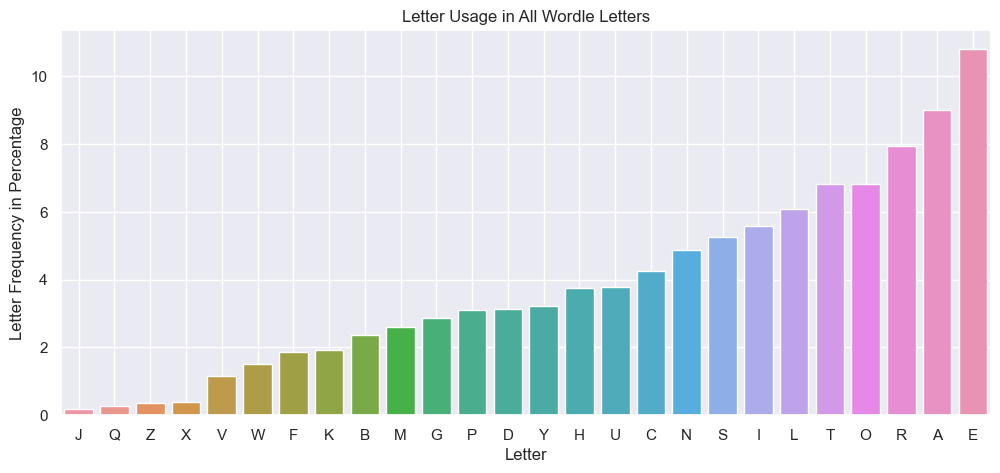

In [556]:
fig, ax = plt.subplots(figsize=(12, 5))
#sns.barplot(letter_percents, x='Letters', y='Count')
sns.barplot(letter_percents, x='Letters', y='Percents')

plt.grid(x)
plt.xlabel("Letter")
#plt.ylabel("Count")
plt.ylabel("Letter Frequency in Percentage")

plt.title("Letter Usage in All Wordle Letters")


## MOST USED

- **Vowel:** E is used in **10.82%** of words
- **Consonant:** R is used in **7.96%** of words

## LEAST USED
- **Vowel:** U is used in **3.79%** of words (and our sometimes Y is used in **3.22%** of words)
- **Consonant:** J is used in just **0.197%** of words


## ODDBALL LETTERS
- **Q**: used in **0.276%** of words
- **Z**: used in **0.375%** of words
- **X**: used in **0.394%** of words
- **J**: the unexpected oddball is used in **0.197%** of words

These 4 letters are the only 4 used in less than **1%** of words. Even V gets used more, about **1.15%** of the time!
___

## Data Analysis: And Sometimes Y... Words Where Y is A Vowel

Our standard vowels are A, E, I, O & U. Our oddball friend is only considered a vowel in a few different instances, and the most notable instance occuring when no other vowel is found in a word. What played Wordle words contain only Y as a vowel?

In [450]:
#wordle_words

In [452]:
y_words = []

for word in wordle_words:
    for letter in word:
        if letter == 'Y':
            y_words.append(word)

#y_words

In [454]:
other_vowels = []
vowels = ['A', 'E', 'I', 'O', 'U']

for word in y_words:
    for letter in word:
        if letter in vowels:
            other_vowels.append(word)


In [455]:
y_vowel = []

for word in y_words:
    if word not in other_vowels:
        y_vowel.append(word)
        
y_vowel

['SHYLY', 'SHYLY', 'GLYPH', 'TRYST', 'NYMPH']

Not sure why SHYLY shows up twice, I confirmed no duplicates exist in the main Wordle words dictionary, so it much have been duplicated during this analysis process.

###  our Y-only words! SHYLY,  GLYPH, TRYST, NYMPH 

---


## Data Analysis: Letter Usage Per Location

Let's say a Wordle word is made up of letters in the sequence --> **[1] [2] [3] [4] [5]**<br>
- How often is each letter used in each location?
- How often do chosen words start with a vowel?
- How often is Q found somewhere else but location [1]?
- I'm sure there's more!

In [424]:
first = []
second = []
third = []
fourth = []
fifth = []

for word in wordle_words:
    first += word[0]
    second += word[1]
    third += word[2]
    fourth += word[3]
    fifth += word[4]

In [422]:
letter_location = pd.DataFrame({'Word': key, 'First': first, 'Second': second, 'Third': third, 'Fourth': fourth, 'Fifth': fifth},
                              columns = ['First','Second','Third','Fourth','Fifth'])

letter_location

,First,Second,Third,Fourth,Fifth
0,R,I,S,E,N
1,D,E,C,A,Y
2,S,H,A,D,E
3,L,I,N,G,O
4,A,B,I,D,E
...,...,...,...,...,...
1008,C,I,G,A,R
1009,B,U,T,C,H
1010,F,E,T,U,S
1011,H,A,R,R,Y


In [145]:
first_counts2 = letter_location['First'].value_counts().reset_index().rename(columns={"First": "Letter", "count": "Counts"}).sort_values(by='Letter')

first_counts = letter_location['First'].value_counts()
# this method is too cumbersome, need to re-evaluate
# couldn't figure out how to re-compile each location count


In [176]:
#for c in letter_location.columns:
    #print ("c")
    #print (letter_location[c].value_counts())

# used this to confirm my work with location_counts belows

In [167]:
location_counts = letter_location.apply(pd.Series.value_counts)
#location_counts

In [166]:
letter_percent = location_counts/word_count*100
letter_percent

,First,Second,Third,Fourth,Fifth
A,7.403751,12.438302,14.807502,7.502468,2.862784
B,7.699901,0.789733,1.974334,0.789733,0.592300
C,8.785785,1.678184,2.566634,6.416584,1.875617
D,3.553801,0.592300,3.060217,3.356367,5.133268
E,3.257651,9.772952,7.798618,12.537019,20.730503
F,5.824284,0.296150,0.691017,1.283317,1.184600
G,5.330701,1.184600,2.665350,3.455084,1.678184
H,3.455084,7.305035,0.493583,1.382034,6.120434
I,1.579467,7.601185,11.352419,7.008885,0.394867
J,0.493583,0.197433,0.197433,0.098717,NaN


### This answers the question of how often each letter is used in each location, in terms of percentage in of Wordle words that have been played.

In [175]:
# just checking my work here
letter_percent['Fifth'].sum()

100.00000000000001

### How often is a given letter used in each position of the current list of Wordle words?

Text(0.5, 1.0, 'What Letters are Used in What Location?')

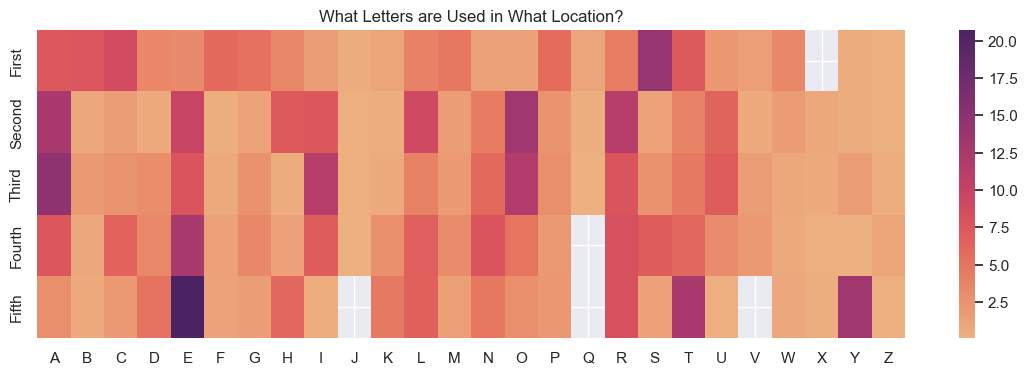

In [579]:
fig, ax = plt.subplots(figsize=(14, 4))
sns.heatmap(letter_percent.transpose(), cmap="flare")
plt.title("What Letters are Used in What Location?")

### This is a really fun breakdown!
- For Letter [1], all letters have been used **except X**
- For Letter [2] & [3], **all letters** have been used
- For Letter [4], all letters have been used **except Q**
- For Letter [5], all letters have been used **except J, Q & V**

### How often does a word start with a vowel?
- A: 7.403751
- E: 3.257651
- I: 1.579467
- O: 1.283317
- U: 2.171767
- Y: 0.493583

For a total of **15.69%** of words! I'm pretty surprised about that. 

In [459]:
vowel_starts = 7.403751 + 3.257651 + 1.579467 + 1.283317 + 2.171767
print(vowel_starts)

# print(f'And sometimes Y: {vowel_starts + 0.493583}')
# apparently Y is not usually considered a vowel when it starts a word!
# learn something new every day



15.695953


---

## Data Analysis: Double (Triple?!) Letter Usage


- How many words played have used a double letter?
- Have any played a triple letter?!
- What letters get used as double (or more) letters?


In [398]:
#wordle_words

In [221]:
wordle_double = []
letter_list = []

for word in wordle_words:
    for letter in word:
        letter_list.append(letter)
        if letter in letter_list:
            wordle_double.append(word)
        else:
            pass


#wordle_double

### Couldn't get this to work as I'd hoped. Want to loop through each word's letters and look for a duplicate. If it appeared, I wanted to append that word to the wordle_double list. I got it working by using sets to remove duplicates and then compare to the original word.

In [204]:
list(wordle_words[14])
    

['C', 'H', 'E', 'E', 'R']

In [205]:
list(set(wordle_words[14]))

['C', 'R', 'E', 'H']

In [206]:
list(set(wordle_words[14])) == list(wordle_words[14])

False

In [404]:
# checking the above logic again the current list

#for word in wordle_words:
    #print(sorted(list(set(word))) == sorted(list(word)))

In [222]:
wordle_double = []
letter_list = []

for word in wordle_words:
    if (sorted(list(set(word))) == sorted(list(word))) == False:
        wordle_double.append(word)
    else:
        pass

wordle_double
        

['LOCAL',
 'HEAVE',
 'CHEER',
 'HUNCH',
 '...',
 'EVADE',
 'AWAKE',
 'HUMPH',
 'SISSY',
 'HARRY',
 'AGORA']

### OK new method worked! Let's take a look at our counts.

In [223]:
len(wordle_double)

296

In [225]:
len(wordle_double)/word_count*100

29.220138203356367

### In Wordle games thus far, 29% of words played have used a double (or triple) letter. At the bottom, we get our evaluation of the 7 rare words that use a triple letter. In the meantime, let's try to figure out what letters are used as a double or triple.

In [342]:
dupe_dictionary = {}

for word in wordle_double:
    for letter in word:
        if (word.count(letter) > 1) == True:
            dupe_dictionary[word] = letter

dupe_dictionary

{'LOCAL': 'L',
 'HEAVE': 'E',
 'CHEER': 'E',
 'HUNCH': 'H',
 'STATE': 'T',
 'SENSE': 'E',
 'PIPER': 'P',
 'APART': 'A',
 'STASH': 'S',
 'PASTA': 'A',
 'NEVER': 'E',
 'STIFF': 'F',
 'WHICH': 'H',
 'REPEL': 'E',
 'VERGE': 'E',
 'EXPEL': 'E',
 'LEGGY': 'G',
 'EMBER': 'E',
 'ALOOF': 'O',
 'STILL': 'L',
 'AGING': 'G',
 'THREE': 'E',
 'EVOKE': 'E',
 'SMALL': 'L',
 'FUNNY': 'N',
 'THESE': 'E',
 'SLEEP': 'E',
 'ADAPT': 'A',
 'GENRE': 'E',
 'SUSHI': 'S',
 'QUEEN': 'E',
 'QUEUE': 'E',
 'TRUST': 'T',
 'SASSY': 'S',
 'GREEN': 'E',
 'NINJA': 'N',
 'LIMIT': 'I',
 'MANIA': 'A',
 'ARDOR': 'R',
 'RETRY': 'R',
 'OCCUR': 'C',
 'SKUNK': 'K',
 'TRUTH': 'T',
 'MERRY': 'R',
 'BERET': 'E',
 'DADDY': 'D',
 'COACH': 'C',
 'LOYAL': 'L',
 'EXERT': 'E',
 'DWELL': 'L',
 'GIDDY': 'D',
 'AWAIT': 'A',
 'ONION': 'N',
 'PEACE': 'E',
 'VERVE': 'E',
 'MAGMA': 'A',
 'AMISS': 'S',
 'HELLO': 'L',
 'BULLY': 'L',
 'BROOK': 'O',
 'POLYP': 'P',
 'BEGET': 'E',
 'TENTH': 'T',
 'WHEEL': 'E',
 'HOBBY': 'B',
 'DROOP': 'O',
 'FOLLY': 

In [538]:
doubles = pd.DataFrame.from_dict(dupe_dictionary, orient='index', columns = ['Letter'])
doubles = doubles.reset_index()
doubles = doubles.rename(columns={'index': 'Word', 'Letter': 'Letter'})

doubles

,Word,Letter
0,LOCAL,L
1,HEAVE,E
2,CHEER,E
3,HUNCH,H
4,STATE,T
...,...,...
291,AWAKE,A
292,HUMPH,H
293,SISSY,S
294,HARRY,R


In [543]:
double_count = pd.DataFrame(doubles.value_counts('Letter'))
double_count.reset_index()

,Letter,count
0,E,65
1,A,34
2,O,31
3,L,27
4,T,21
5,R,18
6,S,18
7,C,12
8,N,9
9,P,8


In [564]:
vowels = ['A', 'E', 'I', 'O', 'U']

Text(0, 0.5, 'Count out of 296 Words')

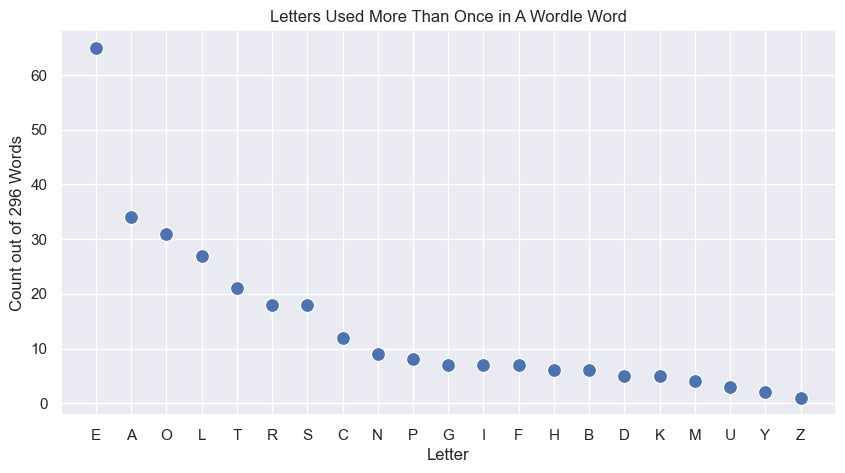

In [582]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x='Letter',y='count',data=double_count, s=100)
plt.title("Letters Used More Than Once in A Wordle Word")
plt.ylabel("Count out of 296 Words")

### Huh, surprised to see U and Y on the list! Wonder what the words are. And I'm going to guess Z appears in PIZZA, let's see.

In [395]:
doubles.query("Letter == 'U'")["Word"]

126    USUAL
131    UNDUE
146    USURP
Name: Word, dtype: object

In [406]:
doubles.query("Letter == 'Y'")["Word"]

74     SHYLY
165    COYLY
Name: Word, dtype: object

In [407]:
doubles.query("Letter == 'Z'")["Word"]

79    JAZZY
Name: Word, dtype: object

### Jazzy! That's a fun one!

In [408]:
doubles.query("Letter == 'K'")["Word"]

41     SKUNK
90     KAYAK
106    KIOSK
128    KNOCK
161    KHAKI
Name: Word, dtype: object

### So there are definitely some unexpected double letters being used over at Wordle! While these oddball doubles are less likely than other words, they clearly have been used and it's worth considering when playing your daily Wordle.

### Let's look at words that use the same letter 3 times!

In [277]:
triple_letters = []
triple_words = []

for word in wordle_double:
    for letter in word:
        if word.count(letter) > 2:
            triple_letters.append(letter)
            triple_words.append(word)
            
        else:
            pass

set(triple_words)
#triple_letters

{'DADDY', 'ERROR', 'FLUFF', 'MUMMY', 'NANNY', 'SASSY', 'SISSY'}

In [278]:
triple_letters = []
triple_words = []

for word in wordle_words:
    for letter in word:
        if word.count(letter) > 2:
            triple_letters.append(letter)
            triple_words.append(word)
            
        else:
            pass

set(triple_words)
#triple_letters

{'DADDY', 'ERROR', 'FLUFF', 'MUMMY', 'NANNY', 'SASSY', 'SISSY'}

---
## Data Analysis: Letter Pairs

- Can we find any interesting information on letter pairs? Thinking “ea” and “ou”, but maybe also “sh” or “th” - maybe consider use of “o” compared to “ou” in terms of percent played.

In [472]:
#wordle2

### From above we know O is 346 times. How many times is OU used?

In [474]:
ou_words = wordle2[wordle2["Word"].str.contains("OU")]

In [477]:
#ou_words

In [475]:
len(ou_words)

39

In [478]:
39/346*100

11.271676300578035

### So 11.3% of the time O is used, it's used with its partner U as an OU pair.

In [479]:
len(wordle2[wordle2["Word"].str.contains("TH")])

40

How many times is SH used in the Wordle words? How often does a word start with SH? End with SH?

In [480]:
len(wordle2[wordle2["Word"].str.contains("SH")])

32

In [481]:
len(wordle2[wordle2["Word"].str.startswith("SH")])

17

In [482]:
len(wordle2[wordle2["Word"].str.endswith("SH")])

12

### Interesting, TH as a pair is used more than SH. Both pairs can be used as the start or the end of a word.
---

## I learned a lot about the statistics of Wordle words here, but I don't think I'll apply many of these learnings to my daily Wordle play. I like the meandering path of guesses and luck that lead to victory, and while this analysis was very interesting, using it daily would take away some of the fun. Although I might avoid using J for a little while after this!!